# Intuitively Explained: Variational Autoencoders

*To paraphrase the brilliant physicist Richard Feynman, "If you can't explain something to a first-year student, you do not truly understand it." Though not as ambitious a goal as Feynman's, this series of posts aims to explain slightly advanced topics using the least formalism possible, usually just basic linear algebra and probability. The goal is to provide substantial intuition made as accessible as possible; it's important to note we're losing some precision this way! These posts will often be accompanied by a partner post on the same topic with code, more mathematical rigor, or both.*

## Part 1: Motivation and Introduction
*What does it mean to make an autoencoder variational, and why could that be useful?*

In the [previous post](https://sachit-menon.github.io/posts/autoencoder-fundamentals/), we discussed the general autoencoder framework for unsupervised learning. (This post assumes you have read that one or are otherwise familiar with the material.) To illustrate the idea, we stepped through the most basic type of autoencoder -- the undercomplete autoencoder -- and used it for a simple dimension reduction task. In this post, we'll now see how the same autoencoder framework can be leveraged towards learning a more interesting representation and in fact the creation of a generative model of our data.

More concretely, we'll be discussing what are called **variational autoencoders**. At a high level, the idea behind them is straightforward. With the undercomplete autoencoder, we were trying to learn a function from our data to a lower-dimensional representation (the *code*) that we could apply our deterministic decoder to and obtain something close to our input. The variational autoencoder extends this idea by considering our learned representation probabilistically. That is, rather than having our encoder output a single vector as our learned representation, we will have it output the parameters of a distribution of latent vectors. 

![VAE Encoder](https://i.imgur.com/HhaVcjp.png?1)
**An illustration of our encoder.** Our input data $\boldsymbol x$ is fed into the encoder function $f$ to create the code; in this case, the code is actually a stack of two vectors, one representing the mean and one representing the variance of the parametrized distributions.

The variational autoencoder as described by Kingma et al. <sup>1</sup> assigns the distributions of each latent variable to be Gaussian. (In fact, our restrictions end up being even more specific, as we will see later.) Considering this case can help us visualize why a probabilistic parametrization allows for richer encoding of information than our deterministic case did. 

In the deterministic case, we aimed to have our encoder map our input down to a point in our $d$-dimensional latent space; that is, a vector in $\mathbb{R}^d$. 

![MNIST Encoding](https://i.imgur.com/SZRJh1H.png?1)
**Traditional encoding.** The input data $\boldsymbol x$ is taken from the original, high-dimensional space to a single point $f(\boldsymbol{x})$ in the lower-dimensional space. This example illustrates an MNIST digit in 784 dimensions being embedded in the 2D plane.

In the probabilistic interpretation, we're instead trying to have our encoder come up with two things: a mean and a variance, both also $d$-dimensional vectors, defining the particular Gaussian that our latent variables are defined by.

![MNIST Distr Encoding](https://i.imgur.com/NgaLPpA.png)

**Encoding for a variational autoencoder.** In this case, the input data $\boldsymbol x$ is taken from the original, high-dimensional space to a *distribution* parametrized by $f(\boldsymbol{x}) = \boldsymbol \mu, \boldsymbol \sigma^2$ in the lower-dimensional space. $\boldsymbol \mu$ corresponds to the point at the center of the 'fuzzy ball,' while the entries of  $\boldsymbol \sigma^2$ correspond to the width of the ball along the corresponding dimensions <sup>2</sup>. This example illustrates an MNIST digit in 784 dimensions being embedded in the 2D plane.

The key introduction here is the variance. This essentially encodes our uncertainty about our point estimate. In fact, our deterministic estimation from before can be considered a particular instantiation of our new probabilistic estimation (as we have formulated it thus far!) in which the variance is fixed to be zero (in other words, where we aim to parametrize a Dirac delta function rather than a Gaussian). Our point estimate is analogous to the estimated mean of the distribution we're fitting. The deterministic approach forces us to define our encoder function as if we are absolutely sure an input should go to the point it maps to, while the probabilistic one allows us more 'wiggle room.' 

## Part 2: It can't be that easy, right?

### 2.1 Latent Representations via Sampling 
By estimating a distribution rather than a point, we (unsurprisingly) introduce new issues. First of all, how is our decoder supposed to map a distribution to a reconstruction of the input? With a point, this was (conceptually) easy; we just had to jointly approximate a function from the code to the reconstruction along with the encoder. If we were to use the expected value of our distribution, we would be doing the same thing as before and our introduction of the variance would be pointless (no pun intended). 

We can achieve the same ease of training by sampling from our distribution and expecting reasonable reconstructions from our samples. These samples give us particular instantiations of the latent variables parametrized by our mean and variance vectors, so this is a reasonable expectation to have.

![Sampling and Decoding](https://i.imgur.com/WDqK0wF.png?1)

**Decoding for a variational autoencoder.** Given a distribution parametrized by $f (\boldsymbol x)$ from the encoder, our decoder draws a sample $\boldsymbol s$ from $f (\boldsymbol x)$ and reconstructs $\boldsymbol x$ as best it can. This example illustrates a point being sampled from a distribution in 2D-space and decoded to 784-dimensional space as an MNIST image.

This also provides us with the rationale for using the variational autoencoder as a generative model; if we can learn a function that encodes distributions over our latent variables and a function that decodes samples, we can take new samples from our latent distributions and pass them through the decoder to generate novel, input-like data.

### 2.2 The Reparametrization Trick 
This gives us vectors to make a decoder with... but now we have a new issue. Our traditional neural network training relies on the backpropagation algorithm, which in turn requires that derivatives be computable at every step along the way. 

Let's think a little harder before throwing away our nice machinery. We know each of the variables we're trying to decode follows a Gaussian distribution. Much like a line can be expressed using a slope and an intercept (e.g. $y = ax+b$ from middle school algebra), arbitrarily distributed Gaussians can be expressed as a 'stretching factor' and a 'shift' (not real terms). That is, it is trivial to express any random variable (such as the entries of our code) $z = N(\mu, \sigma^2)$ as $z = \sigma \epsilon + \mu$, where $\epsilon = N(0,1)$. Here, $\sigma$ is our 'stretching factor' and $\mu$ is our shift.

In doing this, we separate out our (known) source of stochasticity. This can be considered a new external input in addition to the initial input, but crucially, one *we don't care about the derivative of*. Using this form for our latent variables, we can now take the derivatives we wanted for our mean and variance, as our new parametrization is deterministic in those variables. 

This is called the **reparametrization trick** and can be applied anywhere we want to backpropagate through sampling operations for continuous (and, to be a little more pedantic, differentiable 'almost-everywhere') random variables -- the technique is useful for much more than its application in variational autoencoders! Here, though, we will be using it as a silver bullet that allows us to continue with stochastic gradient-based training methods that we would normally use when training a neural network.

### 2.3 Regularization
Now we have a way to train our encoder and decoder jointly to produce distributions describing our latents, just like we said we wanted earlier! So now we have to be done, right?

Not quite. Catching the last complication requires a little more critical thinking; we could now train a network as described above perfectly well given our fixes from the previous two sections, but it would be perfectly useless (as a generative model, at least). 

There are a couple of things to note here. First, we haven't rewarded our network at all for using its dimensions effectively; that is, keeping the random variables for each dimension independent, which would be nice for interpretability and encouraging it to use the constraints we've given it to their fullest. In addition, we realize that if our network is smart enough, it could cheat our distribution-learning game very easily. Given sufficient parameters to manipulate in conjunction with each other, it could take _every input data point_ and shove it to a very different part of the $d$-dimensional space. In other words, it would give them very different means and variances so small as to be near-zero. In this case, it could do a good job reconstructing our specific inputs -- just have the decoder map anything in the general vicinity of where an input went to exactly that input -- but this would be memorizing our input data. If we had a new data point that was not exactly like the ones we had seen already, our network wouldn't know what to do with it other than collapse it to something exactly like a different input it _had_ seen, when what we actually want is some smooth interpolation to make something truly new.

Far apart points... zero variance... huh? In case this sounds sort of familiar, congrats! We've jumped through all these hoops only to end up with the same result that an unregularized, deterministic autoencoder would have given us. 

But hope is not all lost. If we can find a way to discourage our network from doing exactly these things -- that is, penalize it for pushing means far apart, shrinking variances to near-zero, and make latents dependent on one another -- we could be back in business. Fortunately, probability theory gives us a simple way to do this.

Recall that we parametrized our learned distributions over latents as Gaussians. Rather than allowing our network to choose any Gaussians it might want (that could lead us to the fate described above), we want it to choose Gaussians while keeping in mind the three properties we want. This can be enforced by penalizing the loss the further from independent unit Gaussians our distributions become. Doing so would essentially let us tell the network to keep means close to zero (and thus close to each other), variances close to one (and thus not as low as zero), and to keep the latents independent. This may seem like a crazy level of restriction, but I'd like to let three things convince you this is at least somewhat reasonable. One, neural networks are successful at approximating many functions, and given a sufficiently complex transformation we can make unit Gaussians into whatever we want. Two, this is a suggestion we're giving to the network via a penalty, _not_ a constraint we're forcibly imposing on it to make all of them exactly unit Gaussians. Three, it empirically works. (Pretty convincing if not satisfying!)

We can impose this penalty by subtracting off some measure of how different the learned distributions are from independent unit Gaussians from our original loss. Information theory gives us such a construct in what's called the (reverse) KL-divergence. Our new loss -- the difference of the original and the new KL-divergence term -- is referred to as the **variational lower-bound**. 

Finally, we can minimize this new loss via our same stochastic gradient-based methods in order to get a powerful model for unsupervised learning of latent distributions and a great generative model at the same time!


## Part 3: Sampling

As briefly touched on in the previous section, one of the key uses of variational autoencoders is that they can act as *generative models*, giving us novel (but still hopefully realistic) input-like data. As we tried to make our parametrized distributions close to unit Gaussians, we should expect reasonable-looking outputs if we try to sample unit Gaussian noise and decode it. This allows to generate as many as we want, as it is straightforward to sample such noise. 

I trained a simple variational autoencoder with 32 code dimensions, following the description throughout this post; the code for this, with some accompanying implementation explanation, can be found [here](https://github.com/sachit-menon/notebooks/blob/master/vae/vae-implementation.ipynb).

Following this very simple sampling procedure, we obtain outputs such as
![](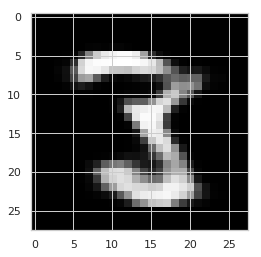%0A)

Despite the very low dimensionality of the code compared to the input, this is very clearly a 3!

## Part 3: Conclusion

In this post, we learned not only what a variational autoencoder is and what it does, but at a high level _how_ it manages to accomplish this. Starting from the notion of a basic, deterministic autoencoder we built our way up and found workarounds for three idea-killing issues -- sampling for inputs to the decoder, the reparametrization technique for stochastic backpropagation, and regularization with the KL-divergence. And we got some idea how it all worked without invoking the terms 'variational Bayes' or even 'posterior' once!

Now that we understand the VAE conceptually, we are well set-up to begin exploring the many interesting extensions that have come of it since its original conception. Look forward to future posts pushing past this intro!

## Footnotes
1. See https://arxiv.org/pdf/1312.6114.pdf.
2. Of course, not every point in the ball is equally likely as we are parametrizing a Gaussian (those closer to the mean have higher probability); furthermore, this representation ignores the fact that the distribution returns *some* probability density everywhere in the space, not just inside the nice little ball we've drawn. But the visual captures the intuition -- we hope most of the points in the space have such low probability that they're essentially zero.